In [40]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
base_dir = '/content/drive/MyDrive/Dataset'

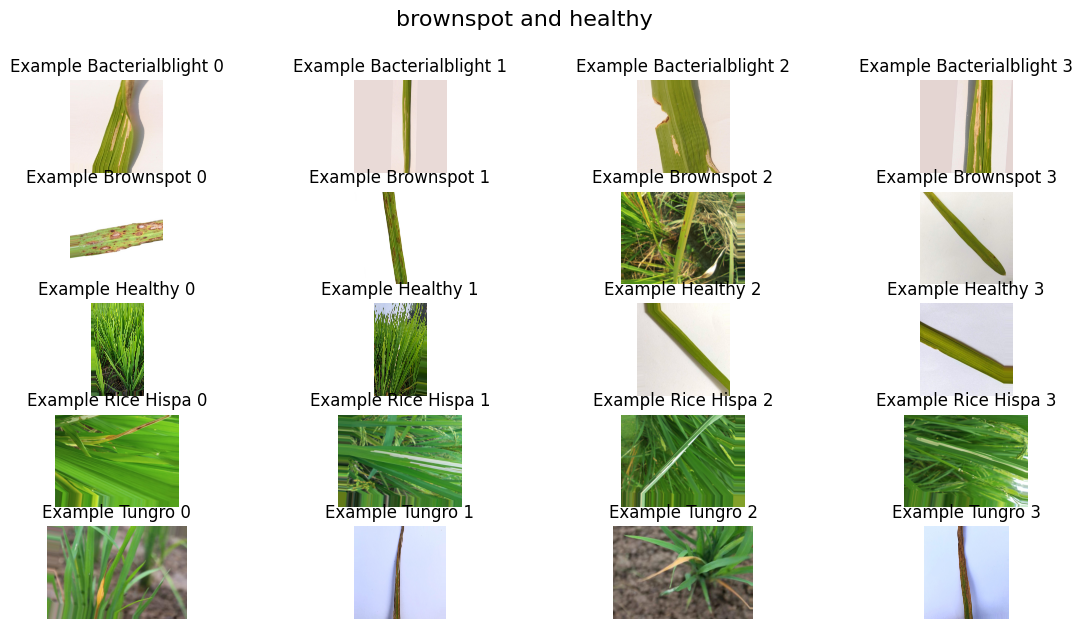

In [6]:
bacterialblight_filenames = [os.path.join(base_dir + '/train/bacterial_leaf_blight', filename) for filename in os.listdir(base_dir + '/train/bacterial_leaf_blight')]
brownspot_filenames = [os.path.join(base_dir + '/train/brown_spot', filename) for filename in os.listdir(base_dir + '/train/brown_spot')]
healthy_filenames = [os.path.join(base_dir + '/train/healthy', filename) for filename in os.listdir(base_dir + '/train/healthy')]
rice_hispa_filenames = [os.path.join(base_dir + '/train/rice_hispa', filename) for filename in os.listdir(base_dir + '/train/rice_hispa')]
tungro_filenames = [os.path.join(base_dir + '/train/tungro', filename) for filename in os.listdir(base_dir + '/train/tungro')]

fig, ax = plt.subplots(5, 4, figsize=(14, 7))
fig.suptitle('brownspot and healthy', fontsize=16)

for i, bacterialblight_image in enumerate(bacterialblight_filenames[:4]):
    img = tf.keras.utils.load_img(bacterialblight_image)
    ax[0, i].imshow(img)
    ax[0, i].set_title(f'Example Bacterialblight {i}')
    ax[0, i].axis('off')

for i, brownspot_image in enumerate(brownspot_filenames[:4]):
    img = tf.keras.utils.load_img(brownspot_image)
    ax[1, i].imshow(img)
    ax[1, i].set_title(f'Example Brownspot {i}')
    ax[1, i].axis('off')

for i, healthy_image in enumerate(healthy_filenames[:4]):
    img = tf.keras.utils.load_img(healthy_image)
    ax[2, i].imshow(img)
    ax[2, i].set_title(f'Example Healthy {i}')
    ax[2, i].axis('off')

for i, rice_hispa_image in enumerate(rice_hispa_filenames[:4]):
    img = tf.keras.utils.load_img(rice_hispa_image)
    ax[3, i].imshow(img)
    ax[3, i].set_title(f'Example Rice Hispa {i}')
    ax[3, i].axis('off')

for i, tungro_image in enumerate(tungro_filenames[:4]):
    img = tf.keras.utils.load_img(tungro_image)
    ax[4, i].imshow(img)
    ax[4, i].set_title(f'Example Tungro {i}')
    ax[4, i].axis('off')

plt.show()

# Create Training, Validation, and Test Dataset

In [7]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [8]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    validation_split=0.2,
    subset="training",
    image_size=(224,224),
    label_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=None,
)

Found 7558 files belonging to 5 classes.
Using 6047 files for training.


In [9]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    validation_split=0.2,
    subset="validation",
    image_size=(224,224),
    label_mode='categorical',
    shuffle=False,
    seed=42,
    batch_size=None,
)

Found 7558 files belonging to 5 classes.
Using 1511 files for validation.


In [10]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    image_size=(224,224),
    label_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=None,
)

Found 1682 files belonging to 5 classes.


In [11]:
batch_size = 32

training_dataset = training_dataset.batch(batch_size, drop_remainder=True) \
                                    .shuffle(100) \
                                    .cache() \
                                    .prefetch(tf.data.AUTOTUNE)

validation_dataset = validation_dataset.batch(batch_size, drop_remainder=True) \
                                        .cache() \
                                        .prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(batch_size, drop_remainder=True) \
                            .cache() \
                            .prefetch(tf.data.AUTOTUNE)

In [12]:
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (32, 224, 224, 3)
Shape of batch of labels: (32, 5)


# Augment Dataset

In [13]:
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([
		    tf.keras.Input(shape=(224, 224,3)),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
    ])

    return augmentation_model

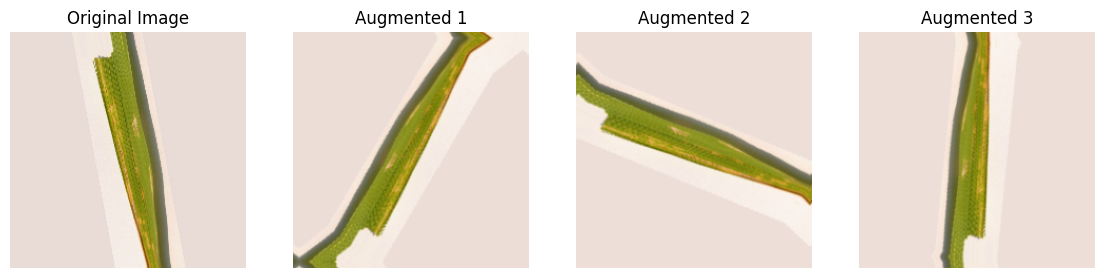

In [14]:
augmentation_layer = create_augmentation_model()

sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

for _ in range(3):
	image_aug = augmentation_layer(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

# Create Model

In [76]:
from tensorflow.keras.applications import VGG16

def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    # x = augmentation_layer(x)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
# def create_model():
#     model = tf.keras.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
#         tf.keras.layers.Rescaling(1./255),
#         augmentation_layer,
#         tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(224, 224, 3)),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(1024, activation='relu'),
#         tf.keras.layers.Dense(5, activation='softmax'),
#     ])
#     return model

In [77]:
model = create_model()

In [78]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [79]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │          10,245 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,775,557 (60.18 MB)

 Trainable params: 1,060,869 (4.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [80]:
history = model.fit(
    training_dataset,
    batch_size=32,
    validation_data=validation_dataset,
    epochs= 50,
    verbose=1 ,
)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.6506 - loss: 0.9122 - val_accuracy: 0.9774 - val_loss: 0.1105
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.8325 - loss: 0.4497 - val_accuracy: 0.9860 - val_loss: 0.0568
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.8652 - loss: 0.3486 - val_accuracy: 0.9894 - val_loss: 0.0399
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.8920 - loss: 0.2978 - val_accuracy: 0.9887 - val_loss: 0.0395
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.8942 - loss: 0.2653 - val_accuracy: 0.9940 - val_loss: 0.0235
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.9109 - loss: 0.2280 - val_accuracy: 0.9927 - val_loss: 0.0341
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.9139 - loss: 0.2150 - val_accuracy: 0.9953 - val_loss: 0.0191
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.9286 - loss: 0

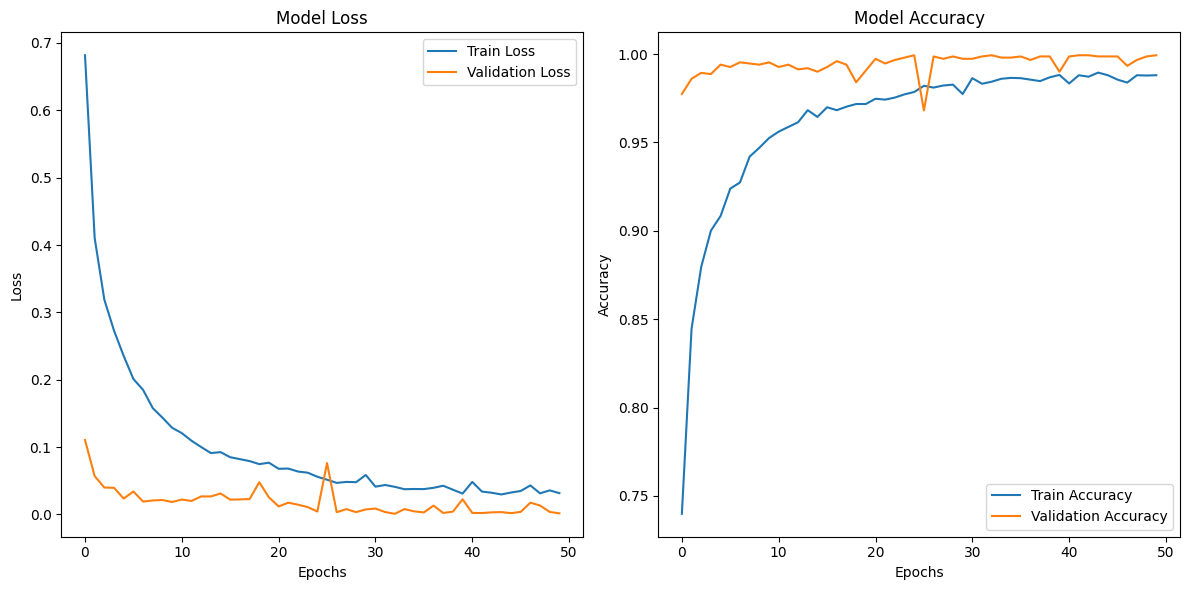

In [81]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Model


In [82]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9800 - loss: 0.0475
Test Loss: 0.055825453251600266
Test Accuracy: 0.9789663553237915


In [83]:
class_names = sorted(os.listdir(train_dir))
print(class_names)

['bacterial_leaf_blight', 'brown_spot', 'healthy', 'rice_hispa', 'tungro']


## Confusion Matrix

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step


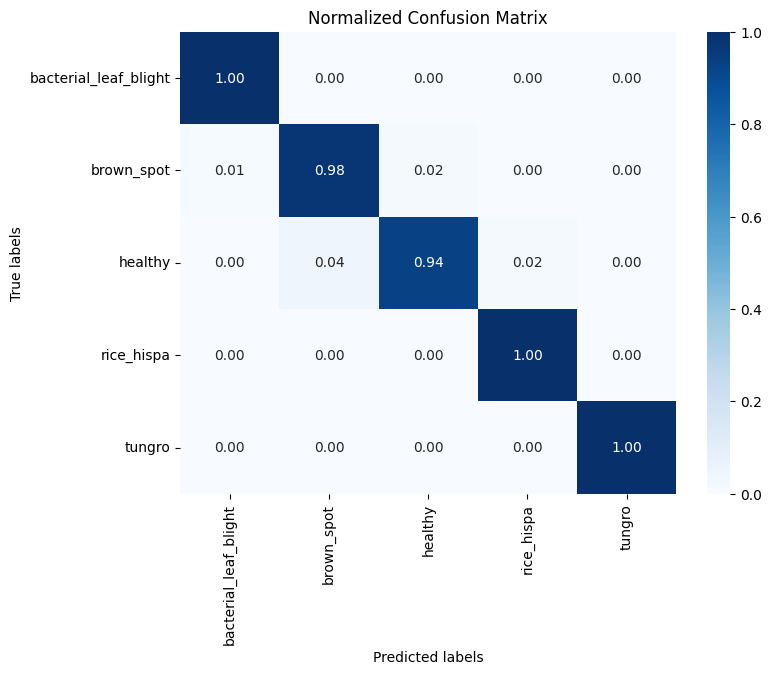

In [114]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

test_labels = np.argmax(test_labels, axis=-1)

predicted_labels = np.argmax(model.predict(test_images), axis=-1)

cm = confusion_matrix(test_labels, predicted_labels)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()


In [115]:
from sklearn.metrics import classification_report

target_names = class_names
report = classification_report(test_labels, predicted_labels, target_names=target_names)

print("Classification Report:\n", report)

Classification Report:
                        precision    recall  f1-score   support

bacterial_leaf_blight       0.99      1.00      0.99       374
           brown_spot       0.96      0.98      0.97       374
              healthy       0.98      0.94      0.96       387
           rice_hispa       0.97      1.00      0.98       224
               tungro       1.00      1.00      1.00       305

             accuracy                           0.98      1664
            macro avg       0.98      0.98      0.98      1664
         weighted avg       0.98      0.98      0.98      1664



## GradCAM

#  Predict Using the Model

In [84]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


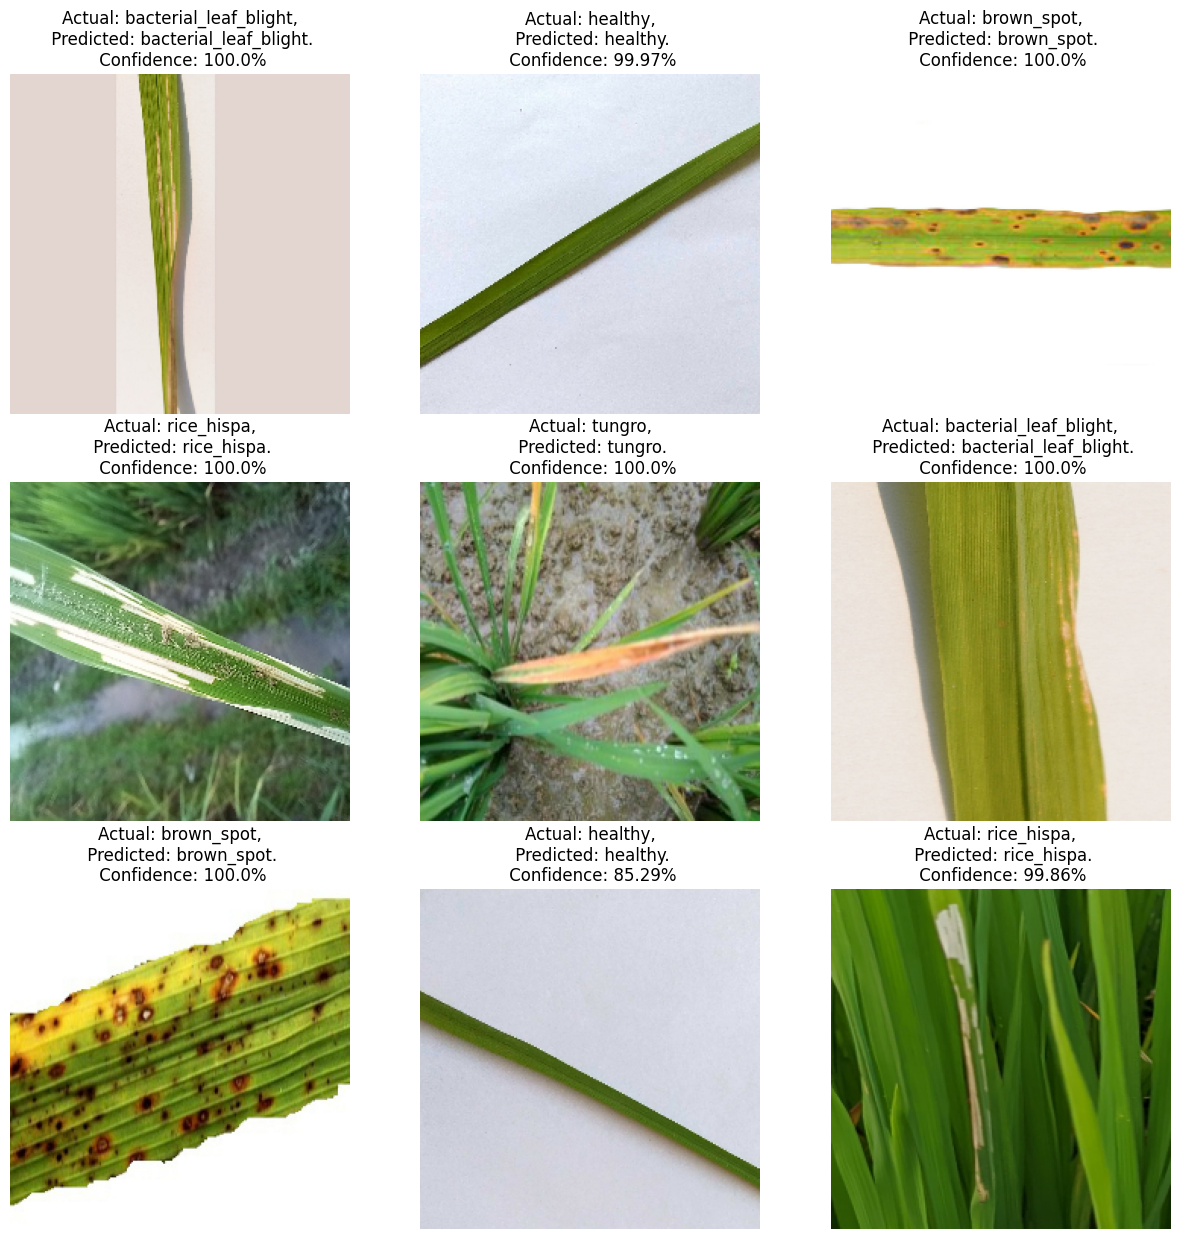

In [85]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())

        if len(labels.shape) > 1:
            label_index = tf.argmax(labels[i]).numpy()
        else:
            label_index = labels[i].numpy()

        actual_class = class_names[label_index]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [144]:
img_path='/content/cochliobolus.jpg'

In [145]:
img = image.load_img(img_path, target_size=(224, 224))

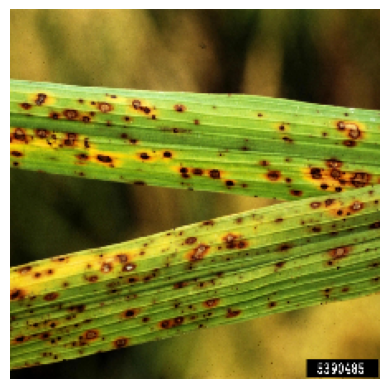

In [146]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [147]:
def predict_from_path(model, img_path, class_names, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)

    predicted_class_index = np.argmax(predictions, axis=-1)[0]

    predicted_class = class_names[predicted_class_index]

    confidence = 100 * np.max(predictions)

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


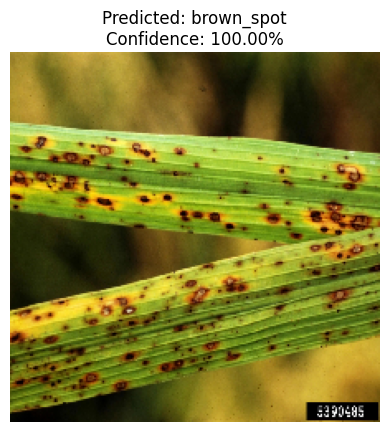

Predicted class: brown_spot, Confidence: 100.00%


In [148]:
predicted_class, confidence = predict_from_path(model, img_path, class_names)

print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}%")

# Save the Model

In [152]:
model.save('rice_leaf_model.keras')

In [153]:
model.save('rice_leaf_model.h5')